/tmp/ipykernel_24434/2311131171.py:21: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv('mosfet_data2.txt', delim_whitespace=True)


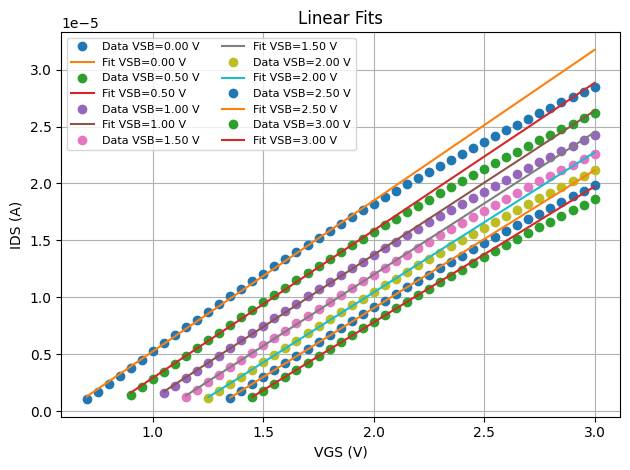

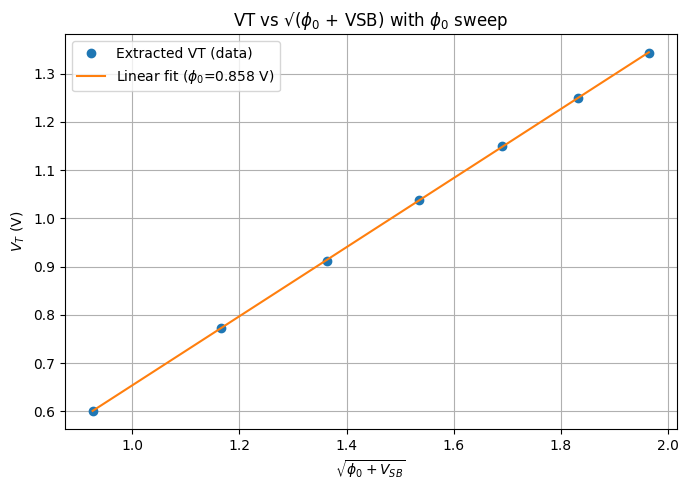

phi_0 = 0.8575757575757577
gamma       = 0.7157171101971929
Vfb    = -0.9192629450746381
Vt = 0.6011054073684341


In [13]:
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import linregress
W = L = 25e-6    
tox = 10.5e-9           
e_ox = 3.45e-11       
cox = e_ox / tox
vds = 1e-1
vgs_min = .5
vgs_max = 3
ids_min = 1e-6
ids_max = 5e-5
bottom_frac = .6
phi0_sweep = np.linspace(0.3, 1.5, 100) 

data = pd.read_csv('mosfet_data2.txt', delim_whitespace=True)
vgs_values = data['VGS'].unique()
data_vds = data[data["VDS"] == vds]
vt_dict = {}
fit_lines = {} 
for vsb in sorted(data_vds["VSB"].unique()):
    subset = data_vds[data_vds["VSB"] == vsb].sort_values("VGS")
    filtered = subset[
        (subset["IDS"].between(ids_min, ids_max)) &
        (subset["VGS"].between(vgs_min, vgs_max))
    ]
    vgs_all = filtered["VGS"].values
    ids_all = filtered["IDS"].values
    n_points = max(2, int(len(ids_all) * bottom_frac))
    vgs = vgs_all[:n_points]
    ids = ids_all[:n_points]
    slope, intercept, r, _, _ = linregress(vgs, ids)
    vt = -intercept / slope
    vt_dict[vsb] = vt
    fit_lines[vsb] = (slope, intercept)
    vgs_fit_full = np.linspace(vgs_all.min(), vgs_all.max(), 200)
    ids_fit_full = slope * vgs_fit_full + intercept
    plt.plot(vgs_all, ids_all, 'o', label=f'Data VSB={vsb:.2f} V')
    plt.plot(vgs_fit_full, ids_fit_full, '-', label=f'Fit VSB={vsb:.2f} V')
plt.xlabel("VGS (V)")
plt.ylabel("IDS (A)")
plt.title("Linear Fits")
plt.grid(True)
plt.legend(fontsize=8, ncol=2)
plt.tight_layout()
plt.show()

vsb_vals = np.array(sorted(vt_dict.keys()))
vt_vals = np.array([vt_dict[v] for v in vsb_vals])
best_phi0 = None
best_r2 = -np.inf
best_fit = None
for phi0 in phi0_sweep:
    x = np.sqrt(phi0 + vsb_vals)
    slope, intercept, r, _, _ = linregress(x, vt_vals)
    r2 = r**2
    if r2 > best_r2:
        best_r2 = r2
        best_phi0 = phi0
        best_fit = (slope, intercept)
gamma, intercept = best_fit
vfb = intercept - best_phi0
vto = vfb + best_phi0 + gamma * np.sqrt(best_phi0)
x_best = np.sqrt(best_phi0 + vsb_vals)
fit_line = best_fit[1] + best_fit[0] * x_best

plt.figure(figsize=(7,5))
plt.plot(x_best, vt_vals, 'o', label='Extracted VT (data)')
plt.plot(x_best, fit_line, '-', label=fr'Linear fit ($\phi_0$={best_phi0:.3f} V)')
plt.xlabel(r'$\sqrt{\phi_0 + V_{SB}}$')
plt.ylabel(r'$V_T$ (V)')
plt.title(r'VT vs √($\phi_0$ + VSB) with $\phi_0$ sweep')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print(f"phi_0 = {best_phi0}")
print(f"gamma       = {gamma}")
print(f"Vfb    = {vfb}")
print(f"Vt = {vto}")


/tmp/ipykernel_24434/2673624166.py:22: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv('mosfet_data2.txt', delim_whitespace=True)


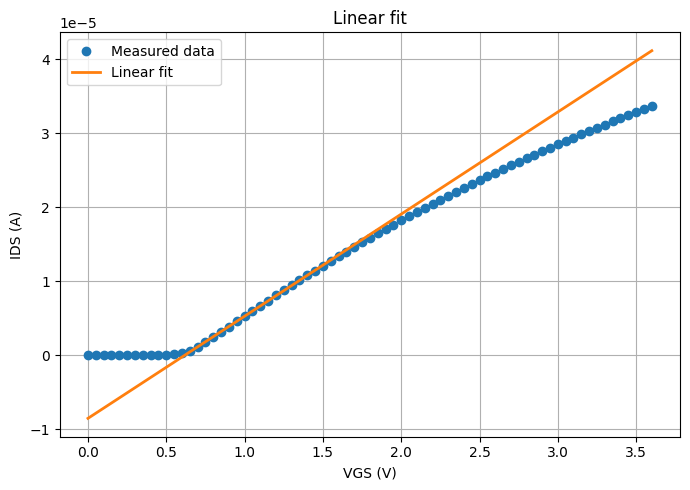

mu_0   = 0.04203022754969263
theta      = 0.12240774141022422


In [14]:
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import linregress

vds = 0.1        
vsb = 0.0         
W = 25e-6               
L = 25e-6
phi_0 = 0.8575757575757577
gamma = 0.7157171101971929
Vfb = -0.9192629450746381
Vt = 0.6011054073684341        
tox = 10.5e-9           
e_ox = 3.45e-11       
cox = e_ox / tox      
bottom_frac = 0.3   
data = pd.read_csv('mosfet_data2.txt', delim_whitespace=True)

data2 = data[(data["VDS"] == vds) & (data["VSB"] == vsb)].copy()
data2.sort_values("VGS", inplace=True)
VGS = data2["VGS"].values
IDS = data2["IDS"].values
filter = (VGS > Vt) & (IDS > 1e-8)
VGS_fit = VGS[filter]
IDS_fit = IDS[filter]
n_points = int(len(VGS_fit) * bottom_frac)
VGS_low = VGS_fit[:n_points]
IDS_low = IDS_fit[:n_points]
slope, intercept, r, _, _ = linregress(VGS_low, IDS_low)
mu0 = slope / (cox * (W / L) * vds)
if len(VGS_fit) > n_points:
    slope_high, _, _, _, _ = linregress(VGS_fit[-n_points:], IDS_fit[-n_points:])
    theta = max(0, (slope - slope_high) / (slope * (VGS_fit[-1] - VGS_fit[0])))
else:
    theta = 0.0
VGS_fit_full = np.linspace(VGS.min(), VGS.max(), 500)
IDS_fit_full = slope * VGS_fit_full + intercept

plt.figure(figsize=(7, 5))
plt.plot(VGS, IDS, 'o', label='Measured data')
plt.plot(VGS_fit_full, IDS_fit_full, '-', label='Linear fit', linewidth=2)
plt.xlabel("VGS (V)")
plt.ylabel("IDS (A)")
plt.title("Linear fit")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print(f"mu_0   = {mu0}")
print(f"theta      = {theta}")




/tmp/ipykernel_24434/1934317459.py:22: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv('mosfet_data2.txt', delim_whitespace=True)


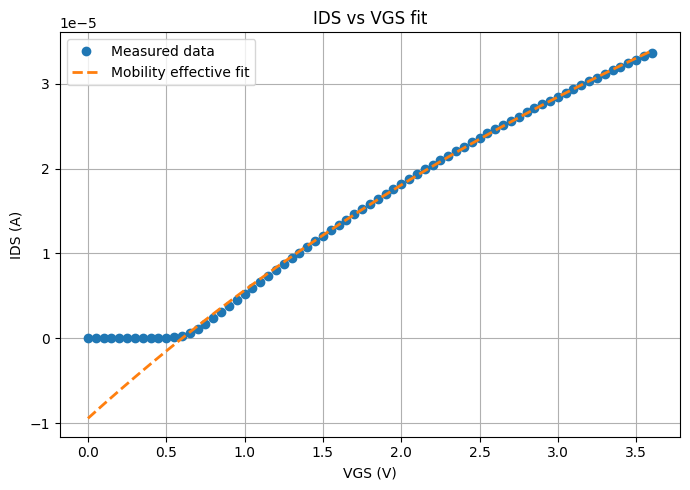

mu_0   = 0.044922252686756155 
theta  = 0.10166357894428904 


In [15]:
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import linregress

vds = 0.1        
vsb = 0.0          
W = 25e-6               
L = 25e-6
phi_0 = 0.8575757575757577
gamma = 0.7157171101971929
Vfb = -0.9192629450746381
Vt = 0.6011054073684341            
tox = 10.5e-9           
e_ox = 3.45e-11       
cox = e_ox / tox      
bottom_frac = 0.3   
data = pd.read_csv('mosfet_data2.txt', delim_whitespace=True)

data2 = data[(data["VDS"] == vds) & (data["VSB"] == vsb)].copy()
data2.sort_values("VGS", inplace=True)
VGS = data2["VGS"].values
IDS = data2["IDS"].values
filter = (VGS > Vt) & (IDS > 1e-8)
VGS_fit = VGS[filter]
IDS_fit = IDS[filter]

def ids_mobility_degradation(VGS, mu0, theta):
    return mu0 * cox * (W/L) * vds * (VGS - Vt) / (1 + theta * (VGS - Vt))

initial_guess = [1e-3, 0.1]
params, covariance = curve_fit(ids_mobility_degradation, VGS_fit, IDS_fit, p0=initial_guess)
mu0_fit, theta_fit = params
VGS_fit_full = np.linspace(VGS.min(), VGS.max(), 500)
IDS_fit_model = ids_mobility_degradation(VGS_fit_full, mu0_fit, theta_fit)

plt.figure(figsize=(7,5))
plt.plot(VGS, IDS, 'o', label='Measured data')
plt.plot(VGS_fit_full, IDS_fit_model, '--', label='Mobility effective fit', linewidth=2)
plt.xlabel("VGS (V)")
plt.ylabel("IDS (A)")
plt.title("IDS vs VGS fit")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print(f"mu_0   = {mu0_fit} ")
print(f"theta  = {theta_fit} ")



/tmp/ipykernel_24434/2459448822.py:24: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv('mosfet_data1.txt', delim_whitespace=True)


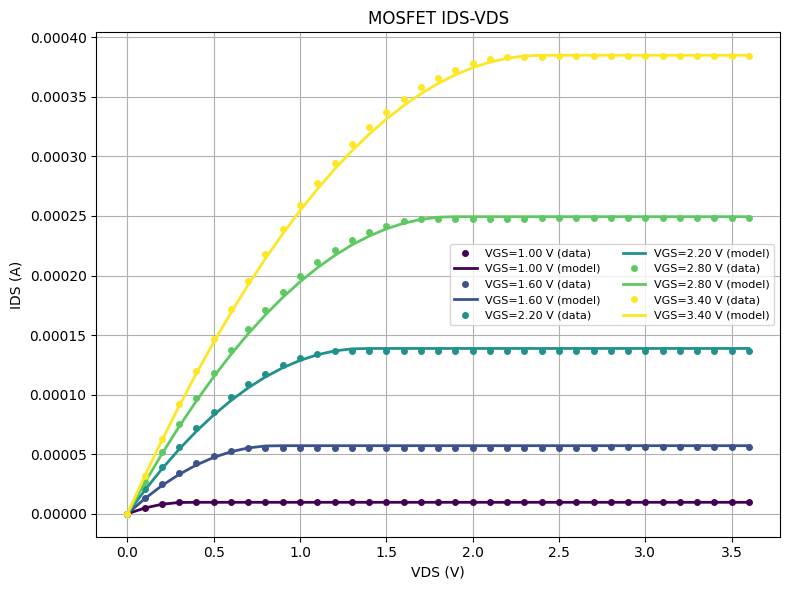

alpha = 1.1693467336683419


In [16]:
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import linregress

vds = 0.1        
vsb = 0.0
mu_0   = 0.044922252686756155 
theta  = 0.10166357894428904        
W = 25e-6               
L = 25e-6
phi_0 = 0.8575757575757577
gamma = 0.7157171101971929
Vfb = -0.9192629450746381
Vt = 0.6011054073684341       
tox = 10.5e-9           
e_ox = 3.45e-11       
cox = e_ox / tox      
bottom_frac = 0.3   
data = pd.read_csv('mosfet_data1.txt', delim_whitespace=True)
alpha_range = np.linspace(0.05, 5, 200)

data_vsb = data[data["VSB"] == vsb]
VDS = data_vsb["VDS"].values
VGS = data_vsb["VGS"].values
IDS = data_vsb["IDS"].values

def mosfet_model(VDS, VGS, alpha):
    VDS_prime = (VGS - Vt) / alpha
    mu_eff = np.where(VGS > Vt, mu_0 / (1 + theta * (VGS - Vt)), 0)
    ids_linear = (W / L) * mu_eff * cox * ((VGS - Vt) * VDS - (alpha / 2) * VDS**2)
    ids_linear = np.where(VDS <= VDS_prime, ids_linear, 0)
    ids_saturation = (W / L) * mu_eff * cox * ((VGS - Vt)**2 / (2 * alpha))
    ids_saturation = np.where(VDS > VDS_prime, ids_saturation, 0)
    return ids_linear + ids_saturation

best_alpha = None
best_r2 = -np.inf

for a in alpha_range:
    IDS_model = mosfet_model(VDS, VGS, a)
    SS_res = np.sum((IDS - IDS_model)**2)
    SS_tot = np.sum((IDS - np.mean(IDS))**2)
    r2 = 1 - SS_res / SS_tot
    if r2 > best_r2:
        best_r2 = r2
        best_alpha = a

plt.figure(figsize=(8,6))
VGS_unique = np.unique(data_vsb["VGS"])
colors = plt.cm.viridis(np.linspace(0,1,len(VGS_unique)))

for vg, color in zip(VGS_unique, colors):
    idx = np.isclose(data_vsb["VGS"], vg)
    VDS_sweep = data_vsb.loc[idx, "VDS"].values
    IDS_meas = data_vsb.loc[idx, "IDS"].values
    sort_idx = np.argsort(VDS_sweep)
    VDS_sorted = VDS_sweep[sort_idx]
    IDS_sorted = IDS_meas[sort_idx]
    IDS_model = mosfet_model(VDS_sorted, vg * np.ones_like(VDS_sorted), best_alpha)
    
    plt.plot(VDS_sorted, IDS_sorted, 'o', color=color, markersize=4, label=f'VGS={vg:.2f} V (data)')
    plt.plot(VDS_sorted, IDS_model, '-', color=color, linewidth=2, label=f'VGS={vg:.2f} V (model)')

plt.xlabel("VDS (V)")
plt.ylabel("IDS (A)")
plt.title("MOSFET IDS-VDS")
plt.grid(True)
plt.legend(fontsize=8, ncol=2)
plt.tight_layout()
plt.show()

print(f"alpha = {best_alpha}")


/tmp/ipykernel_24434/898329672.py:25: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv('mosfet_data1.txt', delim_whitespace=True)


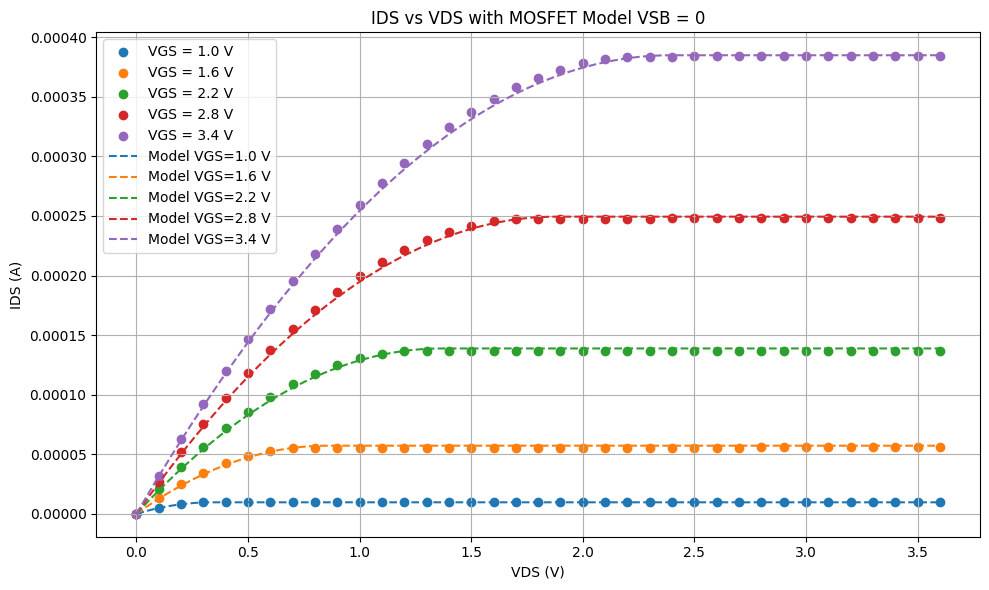

In [17]:
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import linregress

vds = 0.1        
vsb = 0.0
mu_0   = 0.044922252686756155 
theta  = 0.10166357894428904        
W = 25e-6               
L = 25e-6
alpha = 1.1693467336683419
phi_0 = 0.8575757575757577
gamma = 0.7157171101971929
Vfb = -0.9192629450746381
Vt = 0.6011054073684341              
tox = 10.5e-9           
e_ox = 3.45e-11       
cox = e_ox / tox      
bottom_frac = 0.3   
data = pd.read_csv('mosfet_data1.txt', delim_whitespace=True)
data2 = data[data["VSB"] == vsb].copy()
vgs_values = data2['VGS'].unique()

plt.figure(figsize=(10, 6))

def mosfet_model(VDS, VGS):
    VDS_prime = (VGS - Vt) / alpha
    if VGS > Vt:
        mu_eff = mu_0/(1 + theta*(VGS - Vt))
    else:
        mu_eff = 0
    if VDS <= VDS_prime:
        ids1 = (W/L) * mu_eff * cox * ((VGS - Vt) * VDS - (alpha / 2) * VDS**2)
    else:
        ids1 = 0
    if VDS > VDS_prime:
        ids2 = (W/L) * mu_eff * cox * ((VGS - Vt)**2 / (2 * alpha))
    else:
        ids2 = 0
    return ids1 + ids2
for vgs in vgs_values:
    subset = data2[data2['VGS'] == vgs]
    plt.scatter(subset['VDS'], subset['IDS'], label=f'VGS = {vgs:.1f} V')
VDS_range = np.linspace(0, max(data['VDS']), 200)
for vgs in vgs_values:
    IDS_model = [mosfet_model(VDS, vgs) for VDS in VDS_range]
    plt.plot(VDS_range, IDS_model, label=f'Model VGS={vgs:.1f} V', linestyle='--')

plt.xlabel('VDS (V)')
plt.ylabel('IDS (A)')
plt.title('IDS vs VDS with MOSFET Model VSB = 0')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



/tmp/ipykernel_24434/2550266025.py:27: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv('mosfet_data2.txt', delim_whitespace=True)


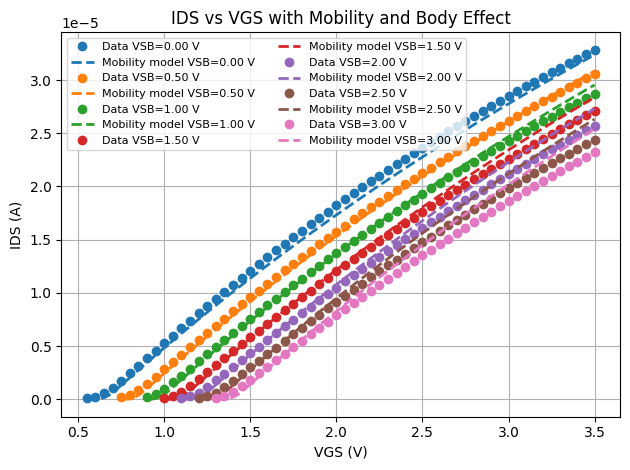

In [18]:
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt

vds = 0.1
mu_0   = 0.044922252686756155 
theta  = 0.10166357894428904        
W = 25e-6               
L = 25e-6
alpha = 1.1693467336683419
phi_0 = 0.8575757575757577
gamma = 0.7157171101971929
Vfb = -0.9192629450746381
Vt = 0.6011054073684341   
tox = 10.5e-9
e_ox = 3.45e-11
cox = e_ox / tox
vgs_min = 0.3
vgs_max = 3.5
ids_min = 1e-7
ids_max = 5e-5
theta_b = 1/.005

data = pd.read_csv('mosfet_data2.txt', delim_whitespace=True)

def ids_mobility(VGS, VSB, VDS=.1):
    Vt = Vfb + phi_0 + gamma * np.sqrt(phi_0 + VSB)
    VDS_prime = (VGS - Vt) / alpha
    mu_eff = np.where(VGS > Vt, mu_0 / (1 + theta * (VGS - Vt)), 0)
    ids1 = np.where((VGS > Vt) & (VDS <= VDS_prime),
                    (W/L) * mu_eff * cox * ((VGS - Vt) * VDS - (alpha/2) * VDS**2),
                    0)
    ids2 = np.where((VGS > Vt) & (VDS > VDS_prime),
                    (W/L) * mu_eff * cox * ((VGS - Vt)**2 / (2*alpha)),
                    0)
    return ids1 + ids2
data_vds = data[data["VDS"] == vds]
for vsb in sorted(data_vds["VSB"].unique()):
    subset = data_vds[data_vds["VSB"] == vsb].sort_values("VGS")
    filtered = subset[
        (subset["IDS"].between(ids_min, ids_max)) &
        (subset["VGS"].between(vgs_min, vgs_max))
    ]
    vgs_all = filtered["VGS"].values
    ids_all = filtered["IDS"].values
    line, = plt.plot(vgs_all, ids_all, 'o', label=f'Data VSB={vsb:.2f} V')
    color = line.get_color()
    vgs_line = np.linspace(vgs_all.min(), vgs_all.max(), 200)
    ids_model = ids_mobility(vgs_line, vsb)
    plt.plot(vgs_line, ids_model, '--', color=color, label=f'Mobility model VSB={vsb:.2f} V', linewidth=2)
plt.xlabel("VGS (V)")
plt.ylabel("IDS (A)")
plt.title("IDS vs VGS with Mobility and Body Effect")
plt.grid(True)
plt.legend(fontsize=8, ncol=2)
plt.tight_layout()
plt.show()


In [19]:
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.optimize import curve_fit

class MOSFET_EKV:
    def __init__(self, W=25e-6, L=25e-6, tox=10.5e-9, e_ox=3.45e-11, vds=0.1,
                 vgs_min=0.3, vgs_max=3.5, ids_min=1e-7, ids_max=5e-5,
                 bottom_frac_6=0.6, bottom_frac_3=0.3):
        self.W = W
        self.L = L
        self.tox = tox
        self.e_ox = e_ox
        self.cox = e_ox / tox
        self.vds = vds
        self.vgs_min = vgs_min
        self.vgs_max = vgs_max
        self.ids_min = ids_min
        self.ids_max = ids_max
        self.bottom_frac_6 = bottom_frac_6
        self.bottom_frac_3 = bottom_frac_3
        self.vt_dict = {}
        self.fit_lines = {}
        self.mu_0 = None
        self.theta = None
        self.alpha = None
        self.phi_0 = None
        self.gamma = None
        self.Vfb = None
        self.Vt0 = None

    def load_data(self, filename):
        self.data = pd.read_csv(filename, delim_whitespace=True)
        return self.data

    def extract_vt(self, vds=None, phi0_sweep=None):
        if vds is not None:
            self.vds = vds
        if phi0_sweep is None:
            phi0_sweep = np.linspace(0.3, 1.5, 100)

        data_vds = self.data[self.data["VDS"] == self.vds]
        self.vt_dict = {}
        self.fit_lines = {}

        for vsb in sorted(data_vds["VSB"].unique()):
            subset = data_vds[data_vds["VSB"] == vsb].sort_values("VGS")
            filtered = subset[
                (subset["IDS"].between(self.ids_min, self.ids_max)) &
                (subset["VGS"].between(self.vgs_min, self.vgs_max))
            ]
            vgs_all = filtered["VGS"].values
            ids_all = filtered["IDS"].values
            n_points = max(2, int(len(ids_all) * self.bottom_frac_6))
            vgs = vgs_all[:n_points]
            ids = ids_all[:n_points]
            slope, intercept, r, _, _ = linregress(vgs, ids)
            vt = -intercept / slope
            self.vt_dict[vsb] = vt
            self.fit_lines[vsb] = (slope, intercept)

        vsb_vals = np.array(sorted(self.vt_dict.keys()))
        vt_vals = np.array([self.vt_dict[v] for v in vsb_vals])
        best_phi0 = None
        best_r2 = -np.inf
        best_fit = None
        for phi0 in phi0_sweep:
            x = np.sqrt(phi0 + vsb_vals)
            slope, intercept, r, _, _ = linregress(x, vt_vals)
            r2 = r**2
            if r2 > best_r2:
                best_r2 = r2
                best_phi0 = phi0
                best_fit = (slope, intercept)
        self.phi_0 = best_phi0
        self.gamma, intercept = best_fit
        self.Vfb = intercept - best_phi0
        self.Vt0 = self.Vfb + self.phi_0 + self.gamma * np.sqrt(self.phi_0)
        return self.phi_0, self.gamma, self.Vfb, self.Vt0

    def extract_mobility(self, vsb=0.0):
        data_copy = self.data[(self.data["VDS"] == self.vds) & (self.data["VSB"] == vsb)].copy()
        data_copy.sort_values("VGS", inplace=True)
        VGS = data_copy["VGS"].values
        IDS = data_copy["IDS"].values
        filter_idx = (VGS > self.Vt0) & (IDS > 1e-8)
        VGS_fit = VGS[filter_idx]
        IDS_fit = IDS[filter_idx]
        n_points = int(len(VGS_fit) * self.bottom_frac_3)
        VGS_low = VGS_fit[:n_points]
        IDS_low = IDS_fit[:n_points]
        slope, intercept, r, _, _ = linregress(VGS_low, IDS_low)
        self.mu_0 = slope / (self.cox * (self.W / self.L) * self.vds)
        if len(VGS_fit) > n_points:
            slope_high, _, _, _, _ = linregress(VGS_fit[-n_points:], IDS_fit[-n_points:])
            self.theta = max(0, (slope - slope_high) / (slope * (VGS_fit[-1] - VGS_fit[0])))
        else:
            self.theta = 0.0
        print(f"mu_0 = {self.mu_0}")
        print(f"theta = {self.theta}")

    def fit_mosfet_model(self, vsb=0.0):
        data_copy = self.data[(self.data["VDS"] == self.vds) & (self.data["VSB"] == vsb)].copy()
        data_copy.sort_values("VGS", inplace=True)
        VGS = data_copy["VGS"].values
        IDS = data_copy["IDS"].values
        filter_idx = (VGS > self.Vt0) & (IDS > 1e-8)
        VGS_fit = VGS[filter_idx]
        IDS_fit = IDS[filter_idx]

        def ids_mobility_degradation(VGS, mu0, theta):
            return mu0 * self.cox * (self.W/self.L) * self.vds * (VGS - self.Vt0)/(1 + theta*(VGS - self.Vt0))

        initial_guess = [1e-3, 0.1]
        params, _ = curve_fit(ids_mobility_degradation, VGS_fit, IDS_fit, p0=initial_guess)
        self.mu_0, self.theta = params

        print(f"Fitted mu_0 = {self.mu_0}")
        print(f"Fitted theta = {self.theta}")

    def extract_alpha(self, datafile='mosfet_data1.txt', vsb=0.0):
        data1 = pd.read_csv(datafile, delim_whitespace=True)
        data_vsb = data1[data1["VSB"] == vsb]
        VDS = data_vsb["VDS"].values
        VGS = data_vsb["VGS"].values
        IDS = data_vsb["IDS"].values

        alpha_range = np.linspace(0.05, 5, 200)
        best_alpha = None
        best_r2 = -np.inf

        def mosfet_model(VDS, VGS, alpha):
            VDS_prime = (VGS - self.Vt0) / alpha
            mu_eff = np.where(VGS > self.Vt0, self.mu_0 / (1 + self.theta*(VGS - self.Vt0)), 0)
            ids_linear = (self.W/self.L) * mu_eff * self.cox * ((VGS - self.Vt0) * VDS - (alpha/2)*VDS**2)
            ids_linear = np.where(VDS <= VDS_prime, ids_linear, 0)
            ids_saturation = (self.W/self.L) * mu_eff * self.cox * ((VGS - self.Vt0)**2 / (2*alpha))
            ids_saturation = np.where(VDS > VDS_prime, ids_saturation, 0)
            return ids_linear + ids_saturation

        for a in alpha_range:
            IDS_model = mosfet_model(VDS, VGS, a)
            SS_res = np.sum((IDS - IDS_model)**2)
            SS_tot = np.sum((IDS - np.mean(IDS))**2)
            r2 = 1 - SS_res/SS_tot
            if r2 > best_r2:
                best_r2 = r2
                best_alpha = a
        self.alpha = best_alpha
        print(f"Best alpha = {self.alpha}")


In [20]:
mosfet = MOSFET_EKV()
mosfet.load_data('mosfet_data2.txt')
mosfet.extract_vt()
mosfet.extract_mobility()
mosfet.fit_mosfet_model()
mosfet.extract_alpha('mosfet_data1.txt')

mu_0 = 0.04155524274599542
theta = 0.11793337125434711
Fitted mu_0 = 0.04377065522597557
Fitted theta = 0.09161133027487267
Best alpha = 1.1693467336683419


/tmp/ipykernel_24434/2980833414.py:37: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  self.data = pd.read_csv(filename, delim_whitespace=True)
/tmp/ipykernel_24434/2980833414.py:126: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data1 = pd.read_csv(datafile, delim_whitespace=True)
